In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=10000)

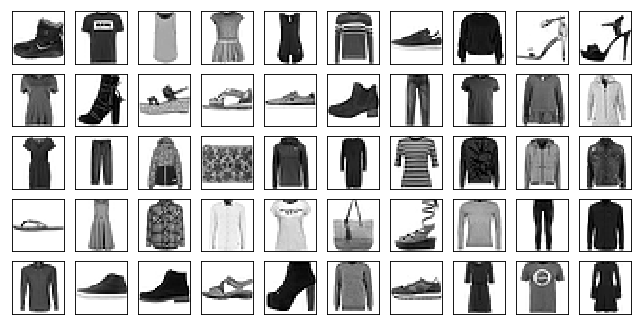

In [3]:
images = fashion_mnist_plotdata()
plot_fashion_mnist(images, (5, 10))

## Обучение классификатора

In [146]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(512)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [147]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [148]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [149]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [150]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [151]:
for epoch in range(1, 51):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.322051 1: 2.296178 2: 2.305676 3: 2.315978
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.329957 1: 0.328799 2: 0.336461 3: 0.348329
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.542690 1: 0.518907 2: 0.556803 3: 0.523033
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.795467 1: 0.694079 2: 0.783434 3: 0.667722
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.303942 1: 0.313490 2: 0.308010 3: 0.308763
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.357306 1: 0.355971 2: 0.341085 3: 0.340370
Test set:
0: Loss: 0.4243	Accuracy: 8502/10000 (85%)
1: Loss: 0.3729	Accuracy: 8626/10000 (86%)
2: Loss: 0.4178	Accuracy: 8531/10000 (85%)
3: Loss: 0.3734	Accuracy: 8625/10000 (86%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.466932 1: 0.432564 2: 0.454312 3: 0.439027
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.357961 1: 0.317428 2: 0.367323 3: 0.308137
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.374297 1: 0.356776 2: 0.359263 3: 0.326697
Train Epoch: 2 [

Train Epoch: 12 [40000/50000 (80%)]	Losses 0: 0.250484 1: 0.234346 2: 0.240227 3: 0.252651
Train Epoch: 12 [50000/50000 (100%)]	Losses 0: 0.134493 1: 0.170854 2: 0.154990 3: 0.112818
Test set:
0: Loss: 0.3001	Accuracy: 8909/10000 (89%)
1: Loss: 0.3056	Accuracy: 8924/10000 (89%)
2: Loss: 0.3021	Accuracy: 8906/10000 (89%)
3: Loss: 0.3299	Accuracy: 8871/10000 (88%)

Train Epoch: 13 [0/50000 (0%)]	Losses 0: 0.116987 1: 0.121078 2: 0.124780 3: 0.112860
Train Epoch: 13 [10000/50000 (20%)]	Losses 0: 0.329229 1: 0.388245 2: 0.361566 3: 0.445939
Train Epoch: 13 [20000/50000 (40%)]	Losses 0: 0.091823 1: 0.094559 2: 0.102863 3: 0.092153
Train Epoch: 13 [30000/50000 (60%)]	Losses 0: 0.259280 1: 0.316011 2: 0.281144 3: 0.362093
Train Epoch: 13 [40000/50000 (80%)]	Losses 0: 0.190686 1: 0.146702 2: 0.172282 3: 0.189601
Train Epoch: 13 [50000/50000 (100%)]	Losses 0: 0.055359 1: 0.046310 2: 0.044651 3: 0.034917
Test set:
0: Loss: 0.3168	Accuracy: 8902/10000 (89%)
1: Loss: 0.3124	Accuracy: 8904/10000 (8

Train Epoch: 24 [10000/50000 (20%)]	Losses 0: 0.103780 1: 0.068110 2: 0.088012 3: 0.060175
Train Epoch: 24 [20000/50000 (40%)]	Losses 0: 0.081623 1: 0.131230 2: 0.092816 3: 0.169582
Train Epoch: 24 [30000/50000 (60%)]	Losses 0: 0.440359 1: 0.354069 2: 0.362113 3: 0.348607
Train Epoch: 24 [40000/50000 (80%)]	Losses 0: 0.116422 1: 0.114272 2: 0.093458 3: 0.111064
Train Epoch: 24 [50000/50000 (100%)]	Losses 0: 0.136961 1: 0.148792 2: 0.147897 3: 0.114701
Test set:
0: Loss: 0.3576	Accuracy: 8935/10000 (89%)
1: Loss: 0.3572	Accuracy: 8885/10000 (88%)
2: Loss: 0.3553	Accuracy: 8912/10000 (89%)
3: Loss: 0.3704	Accuracy: 8920/10000 (89%)

Train Epoch: 25 [0/50000 (0%)]	Losses 0: 0.097834 1: 0.151027 2: 0.108746 3: 0.075311
Train Epoch: 25 [10000/50000 (20%)]	Losses 0: 0.021755 1: 0.043567 2: 0.023255 3: 0.033822
Train Epoch: 25 [20000/50000 (40%)]	Losses 0: 0.121983 1: 0.180609 2: 0.115419 3: 0.175783
Train Epoch: 25 [30000/50000 (60%)]	Losses 0: 0.254556 1: 0.227838 2: 0.237789 3: 0.208460
Tr

Train Epoch: 35 [40000/50000 (80%)]	Losses 0: 0.108204 1: 0.083246 2: 0.030716 3: 0.072898
Train Epoch: 35 [50000/50000 (100%)]	Losses 0: 0.012411 1: 0.082379 2: 0.012133 3: 0.035185
Test set:
0: Loss: 0.4455	Accuracy: 8939/10000 (89%)
1: Loss: 0.4003	Accuracy: 8949/10000 (89%)
2: Loss: 0.4269	Accuracy: 8954/10000 (89%)
3: Loss: 0.4139	Accuracy: 8950/10000 (89%)

Train Epoch: 36 [0/50000 (0%)]	Losses 0: 0.024412 1: 0.032283 2: 0.014704 3: 0.048048
Train Epoch: 36 [10000/50000 (20%)]	Losses 0: 0.122031 1: 0.206660 2: 0.085136 3: 0.227638
Train Epoch: 36 [20000/50000 (40%)]	Losses 0: 0.052001 1: 0.036832 2: 0.045854 3: 0.061103
Train Epoch: 36 [30000/50000 (60%)]	Losses 0: 0.035703 1: 0.037113 2: 0.034460 3: 0.082115
Train Epoch: 36 [40000/50000 (80%)]	Losses 0: 0.056202 1: 0.087717 2: 0.050838 3: 0.167067
Train Epoch: 36 [50000/50000 (100%)]	Losses 0: 0.078644 1: 0.150746 2: 0.106513 3: 0.193230
Test set:
0: Loss: 0.4280	Accuracy: 8971/10000 (89%)
1: Loss: 0.4114	Accuracy: 8916/10000 (8

Train Epoch: 47 [10000/50000 (20%)]	Losses 0: 0.047156 1: 0.059920 2: 0.061039 3: 0.075293
Train Epoch: 47 [20000/50000 (40%)]	Losses 0: 0.132190 1: 0.218215 2: 0.094177 3: 0.147389
Train Epoch: 47 [30000/50000 (60%)]	Losses 0: 0.016043 1: 0.026446 2: 0.009336 3: 0.013135
Train Epoch: 47 [40000/50000 (80%)]	Losses 0: 0.005659 1: 0.014099 2: 0.006624 3: 0.068914
Train Epoch: 47 [50000/50000 (100%)]	Losses 0: 0.003998 1: 0.058225 2: 0.002490 3: 0.030739
Test set:
0: Loss: 0.5332	Accuracy: 8937/10000 (89%)
1: Loss: 0.4948	Accuracy: 8939/10000 (89%)
2: Loss: 0.5320	Accuracy: 8941/10000 (89%)
3: Loss: 0.5086	Accuracy: 8892/10000 (88%)

Train Epoch: 48 [0/50000 (0%)]	Losses 0: 0.044637 1: 0.039669 2: 0.044611 3: 0.168685
Train Epoch: 48 [10000/50000 (20%)]	Losses 0: 0.050365 1: 0.088642 2: 0.031237 3: 0.063752
Train Epoch: 48 [20000/50000 (40%)]	Losses 0: 0.123607 1: 0.028162 2: 0.115878 3: 0.090144
Train Epoch: 48 [30000/50000 (60%)]	Losses 0: 0.042215 1: 0.093235 2: 0.092062 3: 0.081177
Tr

In [155]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

## Вывод результатов

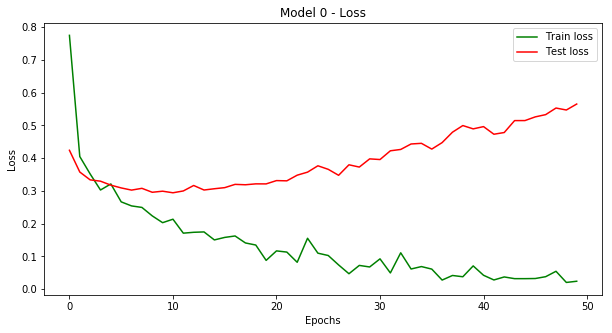

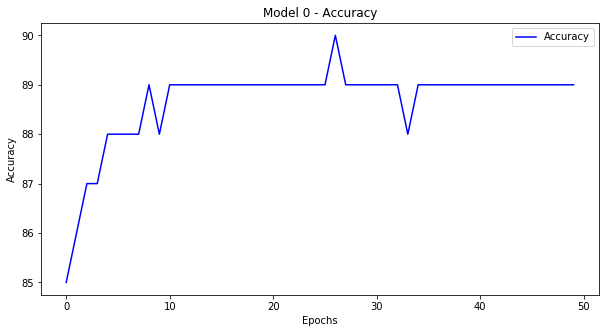

In [156]:
plot_results(0, final_train_loss, final_test_loss, final_test_acc)

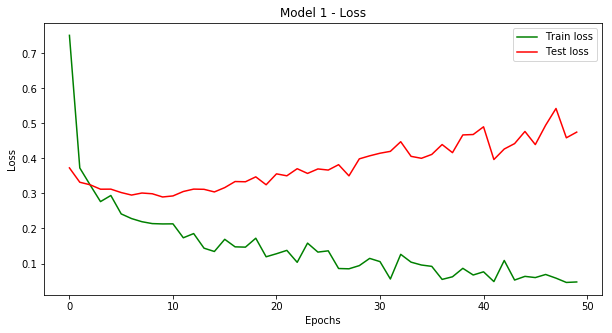

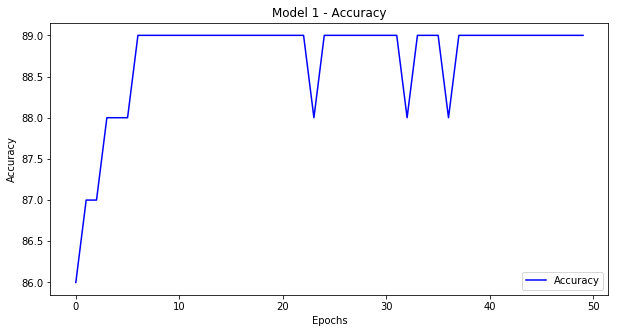

In [157]:
plot_results(1, final_train_loss, final_test_loss, final_test_acc)

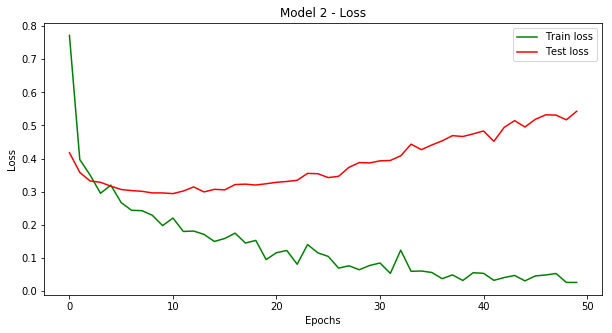

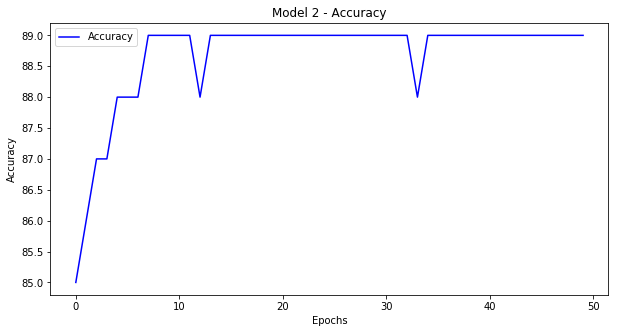

In [158]:
plot_results(2, final_train_loss, final_test_loss, final_test_acc)

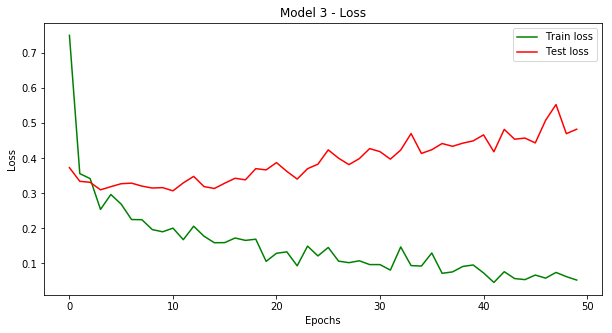

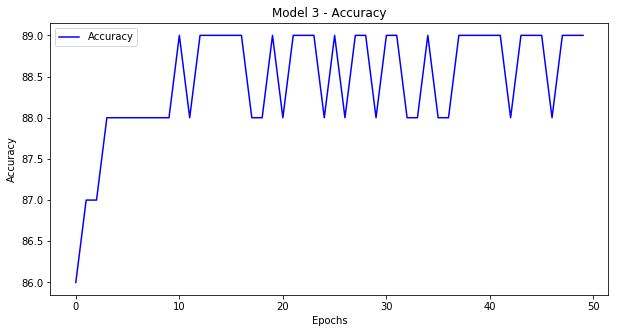

In [159]:
plot_results(3, final_train_loss, final_test_loss, final_test_acc)